In [1]:
import dateutil
import datetime
from datetime import timedelta

import pandas as pd
import requests
from IPython.display import display, HTML, Markdown


%matplotlib inline

In [2]:
access_token = 'some token'

In [3]:
now = datetime.datetime.now()

date_range = pd.date_range(
    start=datetime.datetime(now.year, now.month, now.day, 0, 0, 0),
    end=datetime.datetime(now.year, now.month, now.day, 5, 55, 0),
    freq='5T'
)
df = pd.DataFrame(dict(), index=date_range)
df.index = df.index.map(lambda x: x.time)

for days in range(-13, 1):
    dt = now + datetime.timedelta(days=days)

    date = dt.strftime("%Y-%m-%d")

    resp = requests.get(
        url=f'https://api.fitbit.com/1/user/-/activities/heart/date/{date}/{date}/1sec/time/{"00:00"}/{"06:00"}.json',
        headers={'Authorization': f'Bearer {access_token}'}
    )
    hr_data = resp.json()

    datapoints = hr_data['activities-heart-intraday']['dataset']
    time = [i['time'] for i in datapoints]
    hr = [i['value'] for i in datapoints]
    single_day_df = pd.DataFrame(dict(hr=hr), index=pd.DatetimeIndex(time))
    single_day_df.index = single_day_df.index.map(lambda x: x + datetime.timedelta(days=days))
    
    date_range = pd.date_range(
        start=datetime.datetime(dt.year, dt.month, dt.day, 0, 0, 0),
        end=datetime.datetime(dt.year, dt.month, dt.day, 5, 55, 0),
        freq='5T'
    )

    five_min_averages = []
    for start in date_range:
        end = start + datetime.timedelta(minutes=5)
        mask = (single_day_df.index > start) & (single_day_df.index <= end)
        five_min_selection = single_day_df.loc[mask]
        
        five_min_averages.append(five_min_selection['hr'].mean())
    
    df[dt.strftime("%Y-%m-%d")] = five_min_averages

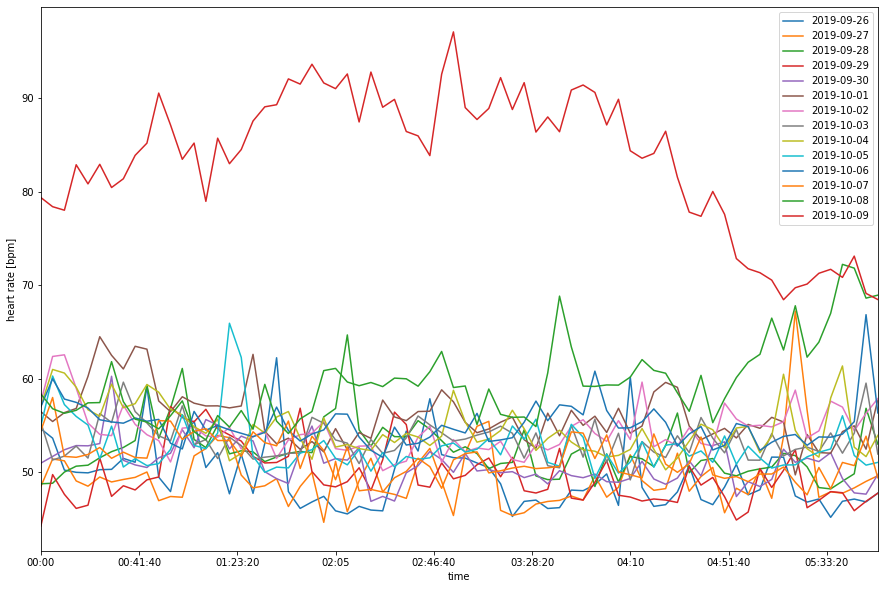

In [4]:
ax = df.plot(figsize=(15,10))
ax.set_ylabel('heart rate [bpm]');